## Load the data

In [1]:
suppressWarnings(suppressMessages(library(tidyverse)))
suppressWarnings(suppressMessages(library(gridExtra)))
suppressWarnings(suppressMessages(library(memisc)))
library(emmeans)

# Load the data
load("~/Documents/holding_gwu_dissertation/data/vcf_data.RData")
paste0("Initial sample: ", nrow(vcf_data))

[1] "Initial sample: 507"

### Impute vaccinated onto intentions scale

In [2]:
# Add a "vaccinated" response to intentions that has a value of 8
vcf_data$base_intention <-  factor(vcf_data$base_intention, 
                                levels = c(levels(vcf_data$base_intention),
                                           "Vaccinated"))
vcf_data$intention_2 <-  factor(vcf_data$intention_2, 
                                levels = c(levels(vcf_data$intention_2),
                                           "Vaccinated"))
vcf_data$intention_4 <-  factor(vcf_data$intention_4, 
                                levels = c(levels(vcf_data$intention_4),
                                           "Vaccinated"))
vcf_data$intention_6 <-  factor(vcf_data$intention_6, 
                                levels = c(levels(vcf_data$intention_6),
                                           "Vaccinated"))

# Recode intentions for vaccinated people as a vaccinated (8) response
vcf_data$intention_2[vcf_data$vax_y_n_2 == "Yes"] <- "Vaccinated"
vcf_data$intention_4[vcf_data$vax_y_n_4 == "Yes"] <- "Vaccinated"
vcf_data$intention_6[vcf_data$vax_y_n_6 == "Yes"] <- "Vaccinated"

### Remove people who didn't follow up

In [3]:
failed_to_follow_up <- vcf_data %>% filter(is.na(sp_confidence_6))
subset <- vcf_data %>% filter(!is.na(sp_confidence_6))
paste0("Dropped for follow-up: ", nrow(failed_to_follow_up), " (", 
       round(nrow(failed_to_follow_up)/nrow(vcf_data),3), ")")
paste0("Analysis Sample: ", nrow(subset))

[1] "Dropped for follow-up: 76 (0.15)"

[1] "Analysis Sample: 431"

### Remove people who weren't paying attention

In [4]:
not_paying_attention <- subset %>% filter(attention2_6 != "Somewhat Agree",
                                               !(participant_id %in% failed_to_follow_up$participant_id))

subset <- vcf_data %>% filter(!is.na(sp_confidence_6), attention2_6 == "Somewhat Agree")
paste0("Dropped for attention-up: ", nrow(not_paying_attention), " (", 
       round(nrow(not_paying_attention)/nrow(vcf_data),3), ")")
paste0("Analysis Sample: ", nrow(subset))

[1] "Dropped for attention-up: 6 (0.012)"

[1] "Analysis Sample: 425"

### Remove people who explicitly stated they were vaccinated prior to the study

In [5]:
vaccinated_prior <- subset %>% filter(
    (vaccinated_prior == TRUE & vax_y_n_2 == "Was already vaccinated prior to joining the study") |
    participant_id == "p_3")
subset <- subset[!(subset$participant_id %in% vaccinated_prior$participant_id), ]

paste0("Dropped for explicitly stating they were vaccinated prior to the study: ", nrow(vaccinated_prior), " (", 
       round(nrow(vaccinated_prior)/nrow(vcf_data),3), ")")
paste0("Analysis Sample: ", nrow(subset))

vaccinated_prior %>% filter(participant_id != "p_3") %>% 
    dplyr::select(base_intention, doses_2, doses_4, doses_6, vax_y_n_2)
vaccinated_prior %>% filter(participant_id == "p_3") %>% 
    dplyr::select(base_intention, intention_6, addressed_concerns_text_6)

[1] "Dropped for explicitly stating they were vaccinated prior to the study: 21 (0.041)"

[1] "Analysis Sample: 404"

base_intention,doses_2,doses_4,doses_6,vax_y_n_2
<fct>,<dbl>,<dbl>,<dbl>,<chr>
Not at all likely,NA,NA,NA,Was already vaccinated prior to joining the study
5,NA,3,3,Was already vaccinated prior to joining the study
3,NA,NA,NA,Was already vaccinated prior to joining the study
Not at all likely,NA,NA,2,Was already vaccinated prior to joining the study
Not at all likely,NA,NA,NA,Was already vaccinated prior to joining the study
Extremely likely,NA,NA,2,Was already vaccinated prior to joining the study
Extremely likely,NA,NA,3,Was already vaccinated prior to joining the study
Not at all likely,NA,3,3,Was already vaccinated prior to joining the study
4,NA,NA,NA,Was already vaccinated prior to joining the study


base_intention,intention_6,addressed_concerns_text_6
<fct>,<fct>,<chr>
Not at all likely,Not at all likely,I am fully vaccinated and boosted. I have no concerns about vaccines.


### Remove people who gave inconsistent responses on vaccination questions

In [6]:
infeasible <- subset %>% filter(vaccinated_prior == TRUE, !is.na(intention_6)) %>% 
    filter(doses_2 >= 2 | doses_4 >= 2 | doses_6 >= 2) %>%
    dplyr::select(mturk_code, group, doses_2, doses_4, doses_6, 
                  intention_2, intention_4, intention_6, vaccinated_prior) %>%
    arrange(desc(doses_2), desc(doses_4), desc(doses_6)) 

subset <- subset %>% filter(!(mturk_code %in% infeasible$mturk_code))
paste0("Dropped for infeasible dose counts: ", nrow(infeasible), " (", 
       round(nrow(infeasible)/nrow(vcf_data),3), ")")
paste0("Analysis Sample: ", nrow(subset))
infeasible

[1] "Dropped for infeasible dose counts: 7 (0.014)"

[1] "Analysis Sample: 397"

mturk_code,group,doses_2,doses_4,doses_6,intention_2,intention_4,intention_6,vaccinated_prior
<chr>,<fct>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<lgl>
983103,Control,3,3,3,Vaccinated,Vaccinated,Vaccinated,TRUE
830458,Control,3,1,3,Vaccinated,Vaccinated,Vaccinated,TRUE
616612,Control,2,2,2,Vaccinated,Vaccinated,Vaccinated,TRUE
699737,Control,2,2,2,Vaccinated,Vaccinated,Vaccinated,TRUE
953099,Gist,2,2,2,Vaccinated,Vaccinated,Vaccinated,TRUE
311050,Gist,2,NA,NA,Vaccinated,5,6,TRUE
645517,Gist,1,3,2,Vaccinated,Vaccinated,Vaccinated,TRUE


In [7]:
vcf_data <- subset %>% filter(!is.na(sp_confidence_6))
paste0("Analysis Sample: ", nrow(vcf_data))

[1] "Analysis Sample: 397"

In [8]:
# Relabel the wave variable
vcf_data$wave <- "Wave 1"
vcf_data$wave[vcf_data$trial == 3] <- "Wave 2"
vcf_data$wave <- factor(vcf_data$wave, levels = c("Wave 1", "Wave 2"))

# Relabel the group variable
vcf_data$group <- vcf_data$group %>% as.character()
vcf_data$group[vcf_data$group == "Gist"] <- "Treatment"
vcf_data$group <- factor(vcf_data$group, levels = c("Treatment", "Control"))

# Baseline
vcf_data$base_intention_n <- vcf_data$base_intention %>% as.numeric()
vcf_data$base_encourage_n <- vcf_data$base_encourage %>% as.numeric()
vcf_data$base_sp_trust_n <- vcf_data$base_sp_trust %>% as.numeric()
vcf_data$base_sp_complacency_n <- vcf_data$base_sp_complacency %>% as.numeric()
vcf_data$base_sp_necessity_n <- vcf_data$base_sp_necessity %>% as.numeric()
vcf_data$base_sp_importance_n <- vcf_data$base_sp_importance %>% as.numeric()
vcf_data$base_sp_confidence_n <- vcf_data$base_sp_confidence %>% as.numeric()
vcf_data$base_sp_safety_n <- vcf_data$base_sp_safety %>% as.numeric()
vcf_data$base_sp_efficacy_n <- vcf_data$base_sp_efficacy %>% as.numeric()

# 6 week
vcf_data$intention_6_n <- vcf_data$intention_6 %>% as.numeric()
vcf_data$encourage_6_n <- vcf_data$encourage_6 %>% as.numeric()
vcf_data$sp_trust_6_n <- vcf_data$sp_trust_6 %>% as.numeric()
vcf_data$sp_complacency_6_n <- vcf_data$sp_complacency_6 %>% as.numeric()
vcf_data$sp_necessity_6_n <- vcf_data$sp_necessity_6 %>% as.numeric()
vcf_data$sp_importance_6_n <- vcf_data$sp_importance_6 %>% as.numeric()
vcf_data$sp_confidence_6_n <- vcf_data$sp_confidence_6 %>% as.numeric()
vcf_data$sp_safety_6_n <- vcf_data$sp_safety_6 %>% as.numeric()
vcf_data$sp_efficacy_6_n <- vcf_data$sp_efficacy_6 %>% as.numeric()

# Gist Items 
vcf_data$gist_cat1_6_n <- vcf_data$gist_cat1_6 %>% as.numeric()
vcf_data$gist_cat2_6_n <- vcf_data$gist_cat2_6 %>% as.numeric()
vcf_data$gist_cat3_6_n <- vcf_data$gist_cat3_6 %>% as.numeric()
vcf_data$gist_cat4_6_n <- vcf_data$gist_cat4_6 %>% as.numeric()
vcf_data$gist_cat5_6_n <- vcf_data$gist_cat5_6 %>% as.numeric()
vcf_data$gist_cat6_6_n <- vcf_data$gist_cat6_6 %>% as.numeric()
vcf_data$gist_cat7_6_n <- vcf_data$gist_cat7_6 %>% as.numeric()
vcf_data$gist_cat8_6_n <- vcf_data$gist_cat8_6 %>% as.numeric()

vcf_data$base_gist_cat1_n <- vcf_data$base_gist_cat1 %>% as.numeric()
vcf_data$base_gist_cat2_n <- vcf_data$base_gist_cat2 %>% as.numeric()
vcf_data$base_gist_cat3_n <- vcf_data$base_gist_cat3 %>% as.numeric()
vcf_data$base_gist_cat4_n <- vcf_data$base_gist_cat4 %>% as.numeric()
vcf_data$base_gist_cat5_n <- vcf_data$base_gist_cat5 %>% as.numeric()
vcf_data$base_gist_cat6_n <- vcf_data$base_gist_cat6 %>% as.numeric()
vcf_data$base_gist_cat7_n <- vcf_data$base_gist_cat7 %>% as.numeric()
vcf_data$base_gist_cat8_n <- vcf_data$base_gist_cat8 %>% as.numeric()

vcf_data$global1_6 <- factor(vcf_data$global1_6, levels = c("None", "Low", "Medium", "High"))
vcf_data$global2_6 <- factor(vcf_data$global2_6, levels = c("None", "Low", "Medium", "High"))                             
vcf_data$base_global1 <- factor(vcf_data$base_global1, levels = c("None", "Low", "Medium", "High"))                             
vcf_data$base_global2 <- factor(vcf_data$base_global2, levels = c("None", "Low", "Medium", "High"))                             
vcf_data$base_global1_n <- vcf_data$base_global1 %>% as.numeric()
vcf_data$base_global2_n <- vcf_data$base_global2 %>% as.numeric()
vcf_data$global1_6_n <- vcf_data$global1_6 %>% as.numeric()
vcf_data$global2_6_n <- vcf_data$global2_6 %>% as.numeric()

vcf_data <- vcf_data %>% 
    mutate(gist1_change = gist_cat1_6_n - base_gist_cat1_n,
           gist2_change = gist_cat2_6_n - base_gist_cat2_n,
           gist3_change = gist_cat3_6_n - base_gist_cat3_n,
           gist4_change = gist_cat4_6_n - base_gist_cat4_n,
           gist5_change = gist_cat5_6_n - base_gist_cat5_n,
           gist6_change = gist_cat6_6_n - base_gist_cat6_n,
           gist7_change = gist_cat7_6_n - base_gist_cat7_n,
           gist8_change = gist_cat8_6_n - base_gist_cat8_n,
           change_risk_princ = risk_princ_6 - base_risk_princ,
           change_resp_princ = resp_princ_6 - base_resp_princ
          )

# Cognitive Reasoning
vcf_data$crt_1_correct <- 0
vcf_data$crt_1_correct[vcf_data$crt_1 %in% 
                         c("500", "500 times", "Probability is half so 500 times")] <- 1
vcf_data$crt_2_correct <- 0
vcf_data$crt_2_correct[vcf_data$crt_2 %in% c("10")] <- 1
vcf_data$crt_3_correct <- 0
vcf_data$crt_3_correct[vcf_data$crt_3 %in% c("1", "1%", "1 percent")] <- 1
vcf_data$crt_sum <- vcf_data$crt_1_correct + vcf_data$crt_2_correct + vcf_data$crt_3_correct

vcf_data$crt_level <- NA
vcf_data$crt_level[vcf_data$crt_sum <= 1] <- "low"
vcf_data$crt_level[vcf_data$crt_sum > 1] <- "high"
vcf_data$crt_level <- factor(vcf_data$crt_level, levels = c("low", "high"))

paste0("Analysis sample: ", nrow(vcf_data))

[1] "Analysis sample: 397"

## Average Gist Measures

In [9]:
vcf_data$gist_cat_6 <- as.numeric(vcf_data$gist_cat1_6) + as.numeric(vcf_data$gist_cat2_6) + 
                       as.numeric(vcf_data$gist_cat3_6) + as.numeric(vcf_data$gist_cat4_6) + 
                       as.numeric(vcf_data$gist_cat5_6) + as.numeric(vcf_data$gist_cat6_6) + 
                       as.numeric(vcf_data$gist_cat7_6) + as.numeric(vcf_data$gist_cat8_6) 

vcf_data$base_gist_cat <- as.numeric(vcf_data$base_gist_cat1) + as.numeric(vcf_data$base_gist_cat2) + 
                          as.numeric(vcf_data$base_gist_cat3) + as.numeric(vcf_data$base_gist_cat4) + 
                          as.numeric(vcf_data$base_gist_cat5) + as.numeric(vcf_data$base_gist_cat6) + 
                          as.numeric(vcf_data$base_gist_cat7) + as.numeric(vcf_data$base_gist_cat8) 

vcf_data$global_6 <- as.numeric(vcf_data$global1_6) + as.numeric(vcf_data$global2_6)
vcf_data$base_global <- as.numeric(vcf_data$base_global1) + as.numeric(vcf_data$base_global2) 

In [10]:
save(vcf_data, file = "~/Documents/holding_gwu_dissertation/data/vcf_data_for_python.RData")

### 2-way ANOVA (Categorical Risk)

In [11]:
pre = vcf_data %>% dplyr::select(id = participant_id, group, score = base_gist_cat) %>% mutate(time = "pretest")
post = vcf_data %>% dplyr::select(id = participant_id, group, score = gist_cat_6) %>% mutate(time = "posttest")
df = bind_rows(pre, post)
df$time <- factor(df$time, levels = c("pretest", "posttest"))
df$group <- factor(df$group, levels = c("Control", "Treatment"))

res <- aov(score ~ group*time + Error(id/time) + group, data = df)
summary(res)


Error: id
           Df Sum Sq Mean Sq F value Pr(>F)
group       1    156   155.6   1.193  0.275
Residuals 395  51489   130.3               

Error: id:time
            Df Sum Sq Mean Sq F value   Pr(>F)    
time         1    923   922.8  29.926 7.98e-08 ***
group:time   1      3     3.3   0.106    0.745    
Residuals  395  12181    30.8                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

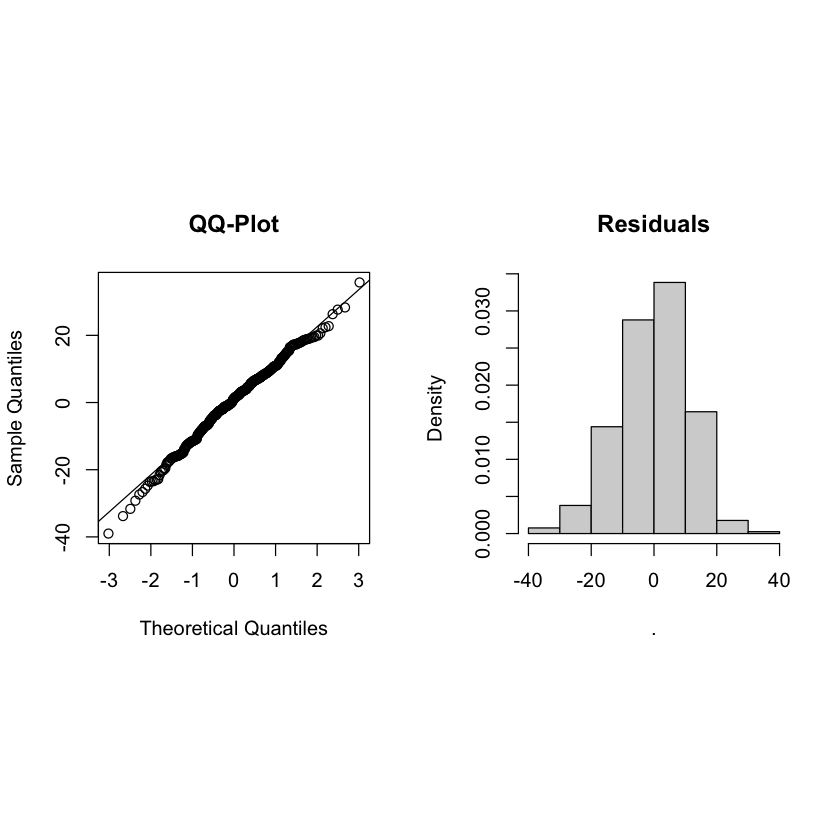

In [12]:
op <- par(pty = "s", mfrow = c(1, 2))
qqnorm(res$id$residuals, main = "QQ-Plot")
qqline(res$id$residuals)
res$id$residuals %>% hist(main = "Residuals", freq = FALSE)

### 2-way ANOVA (Ordinal Risk)

In [13]:
pre = vcf_data %>% dplyr::select(id = participant_id, group, score = base_global) %>% mutate(time = "pretest")
post = vcf_data %>% dplyr::select(id = participant_id, group, score = global_6) %>% mutate(time = "posttest")
df = bind_rows(pre, post)
df$time <- factor(df$time, levels = c("pretest", "posttest"))
df$group <- factor(df$group, levels = c("Control", "Treatment"))

res <- aov(score ~ group*time + Error(id/time) + group, data = df)
summary(res)


Error: id
           Df Sum Sq Mean Sq F value Pr(>F)
group       1      0   0.022   0.008  0.929
Residuals 395   1106   2.801               

Error: id:time
            Df Sum Sq Mean Sq F value Pr(>F)
time         1   1.37  1.3715   1.979  0.160
group:time   1   1.35  1.3522   1.951  0.163
Residuals  395 273.78  0.6931               

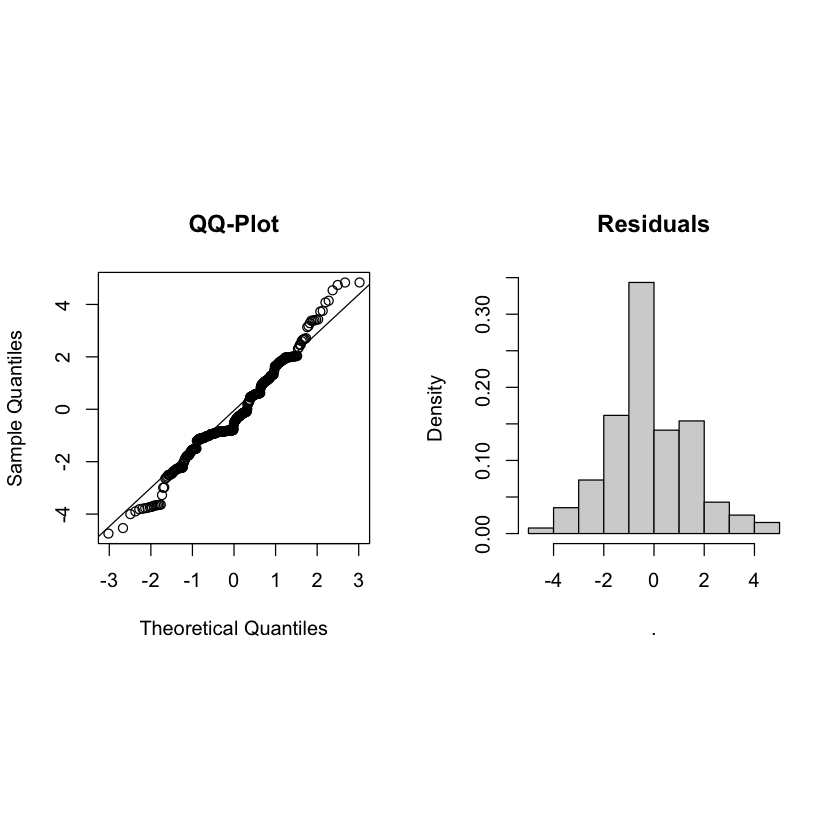

In [15]:
op <- par(pty = "s", mfrow = c(1, 2))
qqnorm(res$id$residuals, main = "QQ-Plot")
qqline(res$id$residuals)
res$id$residuals %>% hist(main = "Residuals", freq = FALSE)